In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
from IPython.core.display import HTML

# Center plots
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Steady State Initial Conditions

One of the issues with the 1-D model of Maroney et al., 2019<sup>[1]</sup>, is that it assumes the puck is initially wet, but no coffee has been dissolved into the liquid. This gives initially low concentration of dissolved coffee in the liquid at the outlet.

Instead, consider how water travels through the puck in an espresso machine, with the puck initially dry, and a "front" of water moving through it. Dissolved solids are pushed toward the outlet, and when the front reaches the outlet we have a nearly stedy state. If the coffee grains are considered as infinite reservoirs of dissolved coffee, we can solve for this steady state.

We start with this equation from Maroney et al.:

$$
\frac{\partial c_l}{\partial t} + v_l \frac{\partial c_l}{\partial z} = \frac{6 D_{v1} \alpha_{s1}}{\alpha_l d_{s1}^2} (c_{s1} - c_l) + \frac{6 D_{v2} \alpha_{s2}}{\alpha_l d_{s2}^2} (c_{s2} - c_l)
$$

Now set $\partial c_l / \partial t = 0$ to get the steady state:

$$
v_l \frac{\partial c_l}{\partial z} = \frac{6 D_{v1} \alpha_{s1}}{\alpha_l d_{s1}^2} (c_{s1} - c_l) + \frac{6 D_{v2} \alpha_{s2}}{\alpha_l d_{s2}^2} (c_{s2} - c_l)
$$

If we let:

$$
A_i = \frac{6 D_{vi} \alpha_{si}}{\alpha_l d_{si}^2}
$$

Then this becomes:

$$
\begin{align}
\frac{\partial c_l}{\partial z} & = \frac{1}{v_l} \left[ A_1(c_{s1} - c_l) + A_2(c_{s2} - c_l) \right] \\
& = \frac{1}{v_l} \left[ A_1 c_{s1} + A_2 c_{s2} - (A_1 + A_2) c_l \right]
\end{align}
$$

This has the solution:

$$
c_l(z) = C e^{-\frac{A_1 + A_2}{v_l} z} + \frac{A_1 c_{s1} + A_2 c_{s2}}{A_1 + A_2}
$$

We want $c_l(0) = 0$, so:

$$
C + \frac{A_1 c_{s1} + A_2 c_{s2}}{A_1 + A_2} = 0 \Rightarrow C = -\frac{A_1 c_{s1} + A_2 c_{s2}}{A_1 + A_2}
$$

And so finally:

$$
c_l(z) = \frac{A_1 c_{s1} + A_2 c_{s2}}{A_1 + A_2} (1 - e^{-\frac{A_1 + A_2}{v_l} z})
$$


# Modelling

Let's try modelling with these initial conditions. First we define the diffusion terms:

In [3]:
def Ai(D_v, a_s, a_l, d_s):
    return (6. * D_v * a_s) / (a_l * d_s**2)

def G(D_v, a_s, a_l, d_s, c_s, c_l):
    return Ai(D_v, a_s, a_l, d_s) * (c_s - c_l)

def H(D_v, phi_v, d_s, c_s, c_l):
    return (6. * D_v) / (phi_v * d_s**2) * (c_s - c_l)

Now the update step:

In [4]:
def update(y, t, v_l, dz, D_v1, D_v2, a_s1, a_l, d_s1, a_s2, d_s2, phi_v1, phi_v2):
    # Parse the interleaved data
    c_l = y[::3]
    c_s1 = y[1::3]
    c_s2 = y[2::3]
    
    # Initialize the return value
    dy_dt = np.empty_like(y)
    
    # Interleaved views of the return value
    dcl_dt = dy_dt[::3]
    dcs1_dt = dy_dt[1::3]
    dcs2_dt = dy_dt[2::3]
    
    # Compute derivatives
    dcl_dt[0] = -v_l * c_l[0] / dz + \
        G(D_v1, a_s1, a_l, d_s1, c_s1[0], c_l[0]) + \
        G(D_v2, a_s2, a_l, d_s2, c_s2[0], c_l[0])
    dcl_dt[1:] = -v_l * (c_l[1:] - c_l[:-1]) / dz + \
        G(D_v1, a_s1, a_l, d_s1, c_s1[1:], c_l[1:]) + \
        G(D_v2, a_s2, a_l, d_s2, c_s2[1:], c_l[1:])

    dcs1_dt[:] = -H(D_v1, phi_v1, d_s1, c_s1, c_l)
    dcs2_dt[:] = -H(D_v2, phi_v2, d_s2, c_s2, c_l)
    
    return dy_dt

And now the constants:

In [5]:
# Constants
a_l = 0.2
a_s1 = 0.5
a_s2 = 0.3

Q = 250. / (1e2)**3 / 60.
A = np.pi * (59e-3 / 2)**2
v_l = Q / (a_l * A)

L = 0.0405
N = 100
dz = L / N

d_s1 = 2.517e-5
d_s2 = 5.63e-4

rho_l = 965.3
h_sl1 = 5.1207e-4 / rho_l
h_sl2 = 1.43e-3 / rho_l

D_v1 = d_s1 * h_sl1
D_v2 = d_s2 * h_sl2

phi_v1 = 0.56
phi_v2 = 0.56

c_s = 358.587

# Simulation time
dt = 0.05
num_t = 250*20
t = np.linspace(0., num_t * dt, num_t)

And initial values:

In [6]:
# Initial values
zs = np.linspace(0., L, N)
A1 = Ai(D_v1, a_s1, a_l, d_s1)
A2 = Ai(D_v2, a_s2, a_l, d_s2)

cl_0 = (A1 * c_s + A2 * c_s) / (A1 + A2) * (1 - np.exp(-(A1 + A2) / v_l * zs))
cs1_0 = np.array([c_s] * N)
cs2_0 = np.array([c_s] * N)

y0 = np.empty(3 * N)
y0[::3] = cl_0
y0[1::3] = cs1_0
y0[2::3] = cs2_0

And now we run `odeint`:

In [7]:
sol = odeint(update, y0, t, args=(v_l, dz, D_v1, D_v2, a_s1, a_l, d_s1, a_s2, d_s2, phi_v1, phi_v2), ml=3, mu=2)
sol

array([[0.00000000e+00, 3.58587000e+02, 3.58587000e+02, ...,
        2.99672228e+02, 3.58587000e+02, 3.58587000e+02],
       [3.89685317e+00, 3.54585727e+02, 3.58084973e+02, ...,
        2.99647540e+02, 3.57925297e+02, 3.58503979e+02],
       [5.35137130e+00, 3.50657248e+02, 3.57587151e+02, ...,
        2.99612339e+02, 3.57270689e+02, 3.58421033e+02],
       ...,
       [3.98874686e-04, 4.55695561e-04, 3.16077928e-01, ...,
        7.78006556e-02, 8.81944289e-02, 8.63308235e-01],
       [3.98313421e-04, 4.55054343e-04, 3.15633169e-01, ...,
        7.76971680e-02, 8.80771315e-02, 8.62201463e-01],
       [3.97752946e-04, 4.54414026e-04, 3.15189035e-01, ...,
        7.75938178e-02, 8.79599899e-02, 8.61096104e-01]])

Let's load the experimental results for plotting:

In [8]:
expt = pd.read_csv('fine_expt_data.csv', header=None, names=['x', 'y'])
expt.head()

,x,y
0,4.975124,211.842105
1,11.940299,150.000000
2,18.905473,76.315789
3,24.875622,43.421053
4,32.835821,27.631579


And plot the results:

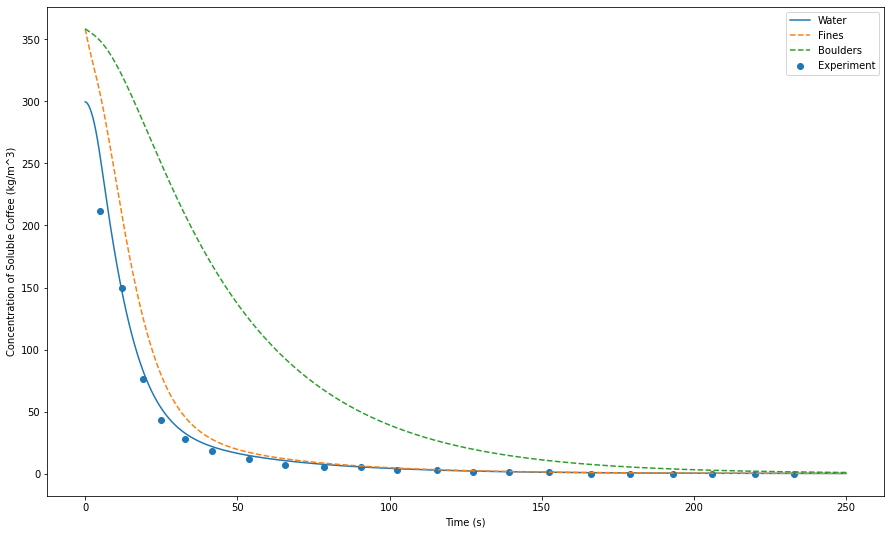

In [9]:
# Get values at the outlet
c_l = sol[:,-3]
c_s1 = sol[:,-2]
c_s2 = sol[:,-1]

# Plot the values
fig, ax = plt.subplots(figsize=(15,9))
ax.plot(t, c_l, label='Water')
ax.plot(t, c_s1, '--', label='Fines')
ax.plot(t, c_s2, '--', label='Boulders')

# Plot the experimental data
ax.scatter(expt['x'], expt['y'], label='Experiment')

# Label the axes
ax.set_xlabel('Time (s)')
ax.set_ylabel('Concentration of Soluble Coffee (kg/m^3)')

# Add a legend
plt.legend()

# Plotting TDS vs. EY

Now we integrate to get the mass of solubles and liquid at the output:

In [10]:
in_s = 0.06
out_s = np.cumsum(Q * (c_l[1:] + c_l[:-1]) / 2. * dt)
out_l = Q * 1e3 * t[1:]

Then we can plot TDS vs. EY:

Text(0, 0.5, 'Total Dissolved Solids (mg/ml)')

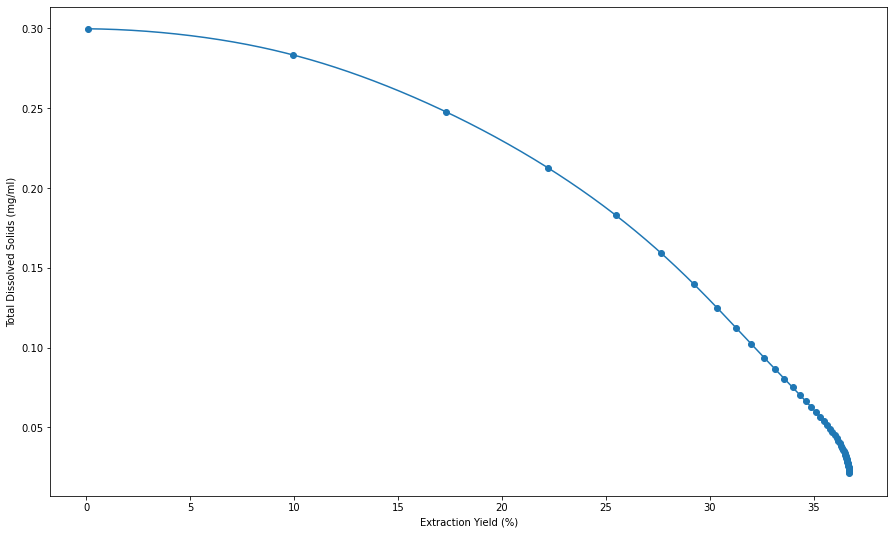

In [11]:
# Plot the values
fig, ax = plt.subplots(figsize=(15,9))
ax.plot(100. * out_s / in_s, out_s / out_l)

# Dots every 5 seconds
ax.scatter(100. * out_s[::100] / in_s, out_s[::100] / out_l[::100])

# Label the axes
ax.set_xlabel('Extraction Yield (%)')
ax.set_ylabel('Total Dissolved Solids (mg/ml)')

# References

[1] Moroney et al., 2019